# Debug MNIST

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow.examples.tutorials.mnist import input_data
import pdb

np.random.seed(0)

# Load Data

In [ ]:
mnist = input_data.read_data_sets('MNIST-Dataset', one_hot=True)

In [ ]:
train_x_raw = mnist.train.images
train_y_raw = mnist.train.labels
valid_x_raw = mnist.validation.images
valid_y_raw = mnist.validation.labels
test_x_raw = mnist.test.images
test_y_raw = mnist.test.labels

## Explore Data

In [ ]:
def plot_mnist(data_x, data_y, n):
    fig = plt.figure(figsize=[16,9])
    for i in range(n):
        ax = fig.add_subplot(n//8, 8, i+1)
        ax.imshow(data_x[i].reshape([28,28]))
        ax.axis('off')
        idx = int(np.nonzero(data_y[i])[0])
        ax.set_title(idx)
    plt.show()

In [ ]:
plot_mnist(train_x_raw, train_y_raw, 32)

In [ ]:
plot_mnist(valid_x_raw, valid_y_raw, 8)

In [ ]:
plot_mnist(test_x_raw, test_y_raw, 8)

In [ ]:
plt.hist(train_x_raw[0:100].flatten(), bins=100);

In [ ]:
print('train mean:', train_x_raw.mean(), 'std', train_x_raw.std())
print('valid mean:', valid_x_raw.mean(), 'std', valid_x_raw.std())
print('test mean:', test_x_raw.mean(), 'std', test_x_raw.std())

## Preprocess Data

In [ ]:
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
test_x = (test_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
test_y = test_y_raw
print('train mean:', train_x.mean(), 'std', train_x.std())
print('valid mean:', valid_x.mean(), 'std', valid_x.std())
print('test mean:', test_x.mean(), 'std', test_x.std())
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

In [ ]:
plot_mnist(train_x, train_y, 8)

# Fast import/restart

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow.examples.tutorials.mnist import input_data
import pdb

np.random.seed(0)

mnist = input_data.read_data_sets('MNIST-Dataset', one_hot=True)

train_x_raw = mnist.train.images
train_y_raw = mnist.train.labels
valid_x_raw = mnist.validation.images
valid_y_raw = mnist.validation.labels
test_x_raw = mnist.test.images
test_y_raw = mnist.test.labels

# Preprocess
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
test_x = (test_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
test_y = test_y_raw

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-Dataset/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-Dataset/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST-Dataset/t10k-images-idx3-ubyte.gz
Extracting MNIST-Dataset/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def subsample_to_14_14(data):
    assert data.ndim == 2
    assert data.shape[1] == 784
    data_28x28 = data.reshape([len(data), 28, 28])  # reshape to match image resolution, new shape (nb_samples, 28, 28)
    print('28', data_28x28.shape)
    data_14x14 = data_28x28[:,::2,::2] # subsample, new shape (nb_samples, 14, 14)
    print('14', data_14x14.shape)
    data_196 = data_14x14.reshape([len(data),14*14])
    print('data_196', data_196.shape)
    assert data_196.ndim == 2
    assert data_196.shape[1] == 196
    return data_196

In [3]:
train_x = subsample_to_14_14(train_x)
valid_x = subsample_to_14_14(valid_x)
test_x = subsample_to_14_14(test_x)

28 (55000, 28, 28)
14 (55000, 14, 14)
data_196 (55000, 196)
28 (5000, 28, 28)
14 (5000, 14, 14)
data_196 (5000, 196)
28 (10000, 28, 28)
14 (10000, 14, 14)
data_196 (10000, 196)


# Activation Functions

These are used for numpy model, but also for plotting later on

In [4]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x)*(1-sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    if deriv:
        return 1. - np.tanh(x)**2
    return np.tanh(x)

def softssign(x, deriv=False):
    if deriv:
        dd = 1 + np.abs(x)
        return (dd - x*np.sign(x)) / dd**2
    return x / (1+np.abs(x))

def relu(x, deriv=False):
    if deriv:
        return 1. * (x>0)
    return np.maximum(0, x)

def lrelu(x, deriv=False):
    if deriv:
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
    return np.where(x > 0, x, x * 0.01)

# Numpy Model

In [ ]:
def MSE(y, y_hat):
    assert y.ndim == 2
    assert y_hat.ndim == 2
    
    # avg over batch, sum over outputs (inner)
    return .5 * np.mean(np.sum((y-y_hat)**2, axis=-1))
    
    # no innner sum, becouse only one output
    return np.mean((y-y_hat)**2)

def acc(y, y_hat):
    return np.mean(np.argmax(y_hat, axis=-1)==np.argmax(y, axis=-1))

def fwd(x, W_hid, W_out, act_fun, ret=False):
    assert x.ndim == 2
    z_hid = x @ W_hid
    h_hid = act_fun(z_hid)  # hidden output

    z_out = h_hid @ W_out
    y_hat = sigmoid(z_out)  # SIGMOID!

    if ret:
        return y_hat, z_hid, h_hid, z_out
    return y_hat

def backprop(x, y, W_hid, W_out, act_fun):
    assert x.ndim == 2
    assert y.ndim == 2
    
    y_hat, z_hid, h_hid, z_out = fwd(x, W_hid, W_out, act_fun, ret=True)
    
    ro_out = (y-y_hat) * -1 * sigmoid(z_out, deriv=True)  # SIGMOID
    dW_out = h_hid.T @ ro_out / len(x)
    
    ro_hid = (ro_out @ W_out.T) * act_fun(z_hid, deriv=True)
    dW_hid = x.T @ ro_hid / len(x)
    
    return dW_hid, dW_out

### Numerical gradient check (optional)

In [ ]:
def ngrad(x, y, W_hid, W_out, act_fun):
    
    eps = 1e-6
    
    gW_hid = np.zeros_like(W_hid)
    for r in range(W_hid.shape[0]):
        for c in range(W_hid.shape[1]):
            W_hid_plus = W_hid.copy()
            W_hid_minus = W_hid.copy()
            W_hid_plus[r,c] += eps
            W_hid_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid_plus, W_out, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid_minus, W_out, act_fun))
            gW_hid[r,c] = (loss_plus-loss_minus) / (2*eps)

    gW_out = np.zeros_like(W_out)
    for r in range(W_out.shape[0]):
        for c in range(W_out.shape[1]):
            W_out_plus = W_out.copy()
            W_out_minus = W_out.copy()
            W_out_plus[r,c] += eps
            W_out_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid, W_out_plus, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid, W_out_minus, act_fun))
            gW_out[r,c] = (loss_plus-loss_minus) / (2*eps)
    return gW_hid, gW_out

In [ ]:
dW_hid, dW_out = backprop(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)
ngW_hid, ngW_out = ngrad(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)

In [ ]:
assert np.allclose(dW_hid, ngW_hid)
assert np.allclose(dW_out, ngW_out)

# Train Loop - with traces

In [29]:
n_in = 196   # 784
n_hid = 128  # 128  # 128             # sigmoid try 8, 128(def.), 2048
n_out = 10
lr = 0.003     # 0.03         # sigmoid try 10, 1(best), 0.03, 0.0003

np_or_tf = 'tf'

n_batch = 100
act_fun = relu
completed_epochs = 0

np.random.seed(0)

# Initialize weights
var_hid = np.sqrt(1/n_in)       # sigmoid try:  0.001,  sqrt(1/n_in),  1
var_out = np.sqrt(1/n_hid)
W_hid = np.random.normal(0.0, var_hid, [n_in, n_hid])
W_out = np.random.normal(0.0, var_out, [n_hid, n_out])

batches = {'iter':[], 'loss':[], 'acc':[]}
valids = {'iter':[], 'loss':[]}
#losses = {'batch':[], 'train':[], 'valid':[]}
#accurs = {'batch':[], 'train':[], 'valid':[]}
traces = {'z_hid':[], 'z_out':[],
          'dW_hid':[], 'dW_out':[],
          'W_hid':[], 'W_out':[]}

In [30]:
import tensorflow as tf

In [31]:
if np_or_tf == 'np':
    print('Skipping graph build')
    
elif np_or_tf == 'tf':
    print('Initializing TensorFlow graph')
    
    try:    sess.close()
    except: pass
    tf.reset_default_graph()
    
    nn_x = tf.placeholder(shape=[None, n_in], dtype=tf.float32)
    nn_y = tf.placeholder(shape=[None, n_out], dtype=tf.float32)

    nn_W_hid = tf.get_variable('nn_W_hid', shape=W_hid.shape, dtype=tf.float32, initializer=tf.constant_initializer(W_hid))
    nn_z_hid = tf.matmul(nn_x, nn_W_hid)
    if act_fun == sigmoid:
        nn_h_hid = tf.nn.sigmoid(nn_z_hid)
    elif act_fun == relu:
        nn_h_hid = tf.nn.relu(nn_z_hid)
    else:
        raise ValueError('unknown activation function')

    nn_W_out = tf.get_variable('nn_W_out', shape=W_out.shape, dtype=tf.float32, initializer=tf.constant_initializer(W_out))
    nn_z_out = tf.matmul(nn_h_hid, nn_W_out)
    nn_y_hat = tf.nn.sigmoid(nn_z_out)  # output always sigmoid

    nn_mse = .5 * tf.reduce_mean( tf.reduce_sum(tf.pow(nn_y-nn_y_hat, 2), axis=-1) )
    nn_acc = tf.reduce_mean( 
                tf.cast( 
                    tf.equal( tf.argmax(nn_y_hat, axis=-1), tf.argmax(nn_y, axis=-1) )
                , tf.float32)
            )

    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
    # train_op = optimizer.minimize(nn_mse)

    grads_and_vars = optimizer.compute_gradients(nn_mse)
    train_op = optimizer.apply_gradients(grads_and_vars)

    nn_dW_hid = grads_and_vars[0][0]
    nn_dW_out = grads_and_vars[1][0]

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

Initializing TensorFlow graph


In [32]:
ti_ = 0
train_i = np.array(range(len(train_x)))
for e in range(10):
    print(e)
    np.random.shuffle(train_i)
            
    for i in range(0, len(train_x), n_batch):

        # Get 128 sized batch, both as 2d arrays   
        batch = train_i[i:i+n_batch]
        x = train_x[batch]
        y = train_y[batch]
        
        if np_or_tf == 'np':
            
            if ti_ == 0:
                print('Executing Numpy version')
            
            # Forward pass
            y_hat, z_hid, _, z_out = fwd(x, W_hid, W_out, act_fun, ret=True)
            loss = MSE(y, y_hat)
            accuracy = acc(y, y_hat)
            
            # Backpropagation
            dW_hid, dW_out = backprop(x, y, W_hid, W_out, act_fun)
            W_hid += -lr * dW_hid
            W_out += -lr * dW_out
            
        elif np_or_tf == 'tf':
            
            if ti_ == 0:
                print('Executing Tensorflow version')
            
            _, y_hat, z_hid, z_out, loss, accuracy, dW_hid, dW_out, W_hid, W_out = sess.run(
                [train_op, nn_y_hat, nn_z_hid, nn_z_out, nn_mse, nn_acc, nn_dW_hid, nn_dW_out, nn_W_hid, nn_W_out],
                feed_dict={nn_x: x, nn_y:y})
            W_hid, W_out = sess.run(tf.trainable_variables())
            
            loss_val = sess.run(nn_mse, feed_dict={nn_x: valid_x, nn_y:valid_y})
            
            assert y_hat.shape == y.shape
            assert np.isscalar(loss)
            assert np.isscalar(accuracy)
            
        else:
            raise ValueError('np_or_tf must be "np" or "tf"')
        
        batches['iter'].append(ti_)
        batches['loss'].append(loss)
        batches['acc'].append(accuracy)
        
        valids['iter'].append(ti_)
        valids['loss'].append(loss_val)
        
        traces['z_hid'].append(z_hid)
        traces['z_out'].append(z_out)
        traces['dW_hid'].append(dW_hid)
        traces['dW_out'].append(dW_out)
        traces['W_hid'].append(W_hid.copy())
        traces['W_out'].append(W_out.copy())

        ti_ += 1
        
    completed_epochs += 1
    
act_fun_to_str = {sigmoid:'sig', tanh:'tanh', softssign:'softsign', relu:'relu'}
expstr = 'Network(' + np_or_tf + '): '
expstr += str(n_in) + 'in->' + str(n_hid) + act_fun_to_str[act_fun] + '->' + str(n_out) + 'sig   '
expstr += 'init_var=[' + str(round(var_hid, 3)) + ',' + str(round(var_out,3))+ ']   '
expstr += 'lr=' + str(lr) + '   '
expstr += 'batch=' + str(n_batch) + '   '
expstr += 'epochs=' + str(completed_epochs)

tr_z_hid = np.array(traces['z_hid'])
tr_z_out = np.array(traces['z_out'])
tr_dW_hid = np.array(traces['dW_hid'])
tr_dW_out = np.array(traces['dW_out'])
tr_W_hid = np.array(traces['W_hid'])
tr_W_out = np.array(traces['W_out'])

print('tr_z_hid', tr_z_hid.shape, tr_z_hid.size/1e6)
print('tr_z_out', tr_z_out.shape, tr_z_out.size/1e6)
print('tr_dW_hid', tr_dW_hid.shape, tr_dW_hid.size/1e6)
print('tr_dW_out', tr_dW_out.shape, tr_dW_out.size/1e6)
print('tr_W_hid', tr_W_hid.shape, tr_W_hid.size/1e6)
print('tr_W_out', tr_W_out.shape, tr_W_out.size/1e6)

print(expstr)

0
Executing Tensorflow version
1
2
3
4
5
6
7
8
9
tr_z_hid (0,) 0.0
tr_z_out (0,) 0.0
tr_dW_hid (0,) 0.0
tr_dW_out (0,) 0.0
tr_W_hid (0,) 0.0
tr_W_out (0,) 0.0
Network(tf): 196in->128relu->10sig   init_var=[0.071,0.088]   lr=0.003   batch=100   epochs=10


In [ ]:
print('Final train loss:', losses['train'][-1])
print('Final valid loss:', losses['valid'][-1])

In [ ]:
train_y_hat = fwd(train_x, W_hid, W_out, act_fun)
train_loss = MSE(train_y, train_y_hat)
train_loss

In [ ]:
valid_y_hat = fwd(valid_x, W_hid, W_out, act_fun)
valid_loss = MSE(valid_y, valid_y_hat)
valid_loss

# Loss, output

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


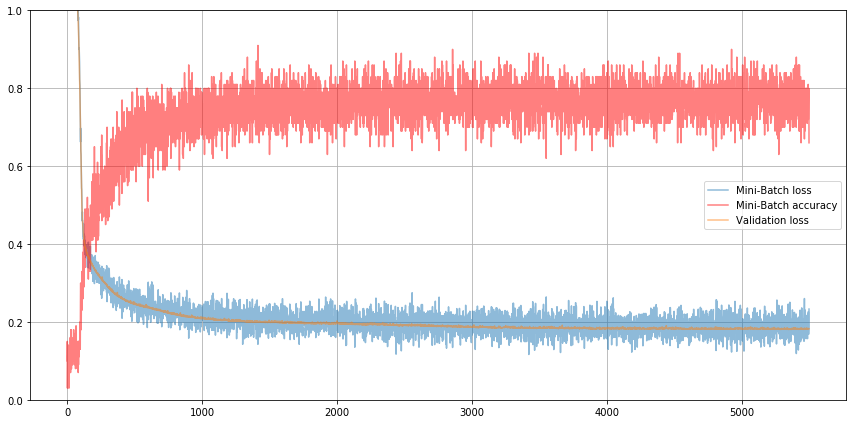

In [55]:
#
#   Plot Loss, Accuracy
#
print(expstr)
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(batches['iter'], batches['loss'], label='Mini-Batch loss', alpha=.5)
ax.plot(batches['iter'], batches['acc'], label='Mini-Batch accuracy', color='red', alpha=.5)
ax.plot(valids['iter'], valids['loss'], label='Validation loss', alpha=.5)

ax.legend()
ax.set_ylim(0, 1)
ax.grid()

plt.tight_layout()
plt.show;

---

In [11]:
def plot_class_coverage(y, y_hat, axis=None):
    #
    #   Per-class accuracy
    #
    assert y.ndim == 2 and y_hat.ndim == 2
    assert y.shape == y_hat.shape
    
    nb_classses = y.shape[-1]
    
    y_correct = np.argmax(y, axis=-1) == np.argmax(y_hat, axis=-1)
    classes_correct = []
    classes_all = []
    for i in range(nb_classses):
        is_y_class_i = y_correct * (np.argmax(y, axis=-1)==i)
        nb_correct_class_i = np.sum(is_y_class_i)
        classes_correct.append(nb_correct_class_i)
        classes_all.append(np.count_nonzero(np.argmax(y, axis=-1)==i))
    classes_correct = np.array(classes_correct)
    classes_all = np.array(classes_all)

    if axis is None:
        fig, axis = plt.subplots()
    
    axis.bar(range(10), classes_all, label='All Member')
    axis.bar(range(10), classes_correct, label='Correctly Predicted')
    axis.legend(loc=3)

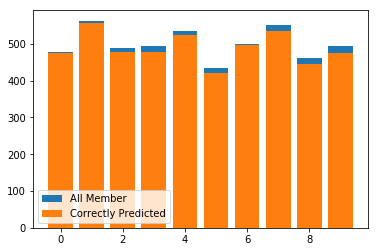

In [34]:
data_x, data_y = valid_x, valid_y
if np_or_tf == 'np':     y_hat = fwd(data_x, W_hid, W_out, act_fun)
elif np_or_tf == 'tf':   y_hat = sess.run(nn_y_hat, feed_dict={nn_x: data_x})
else:                    raise ValueError()
plot_class_coverage(data_y, y_hat)

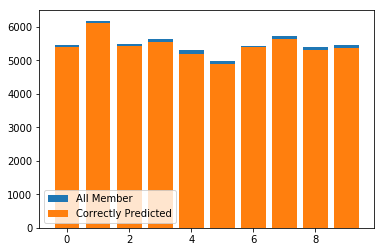

In [35]:
data_x, data_y = train_x, train_y
if np_or_tf == 'np':     y_hat = fwd(data_x, W_hid, W_out, act_fun)
elif np_or_tf == 'tf':   y_hat = sess.run(nn_y_hat, feed_dict={nn_x: data_x})
else:                    raise ValueError()
plot_class_coverage(data_y, y_hat)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,9])
plot_gradients(tr_dW_out, neuron_nb='all', title='tr_dW_out', color='blue', axis=ax)

# Weight Plots

In [12]:
def running_mean(x, n):
    return np.array([ np.mean(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [13]:
def running_std(x, n):
    return np.array([ np.std(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [14]:
def plot_weights(data_iwn, neuron_nb, title=None, axis=None):
    assert data_iwn.ndim == 3
    assert np.isscalar(neuron_nb)
    
    ni, nw, nn = data_iwn.shape   # iter, weights
    
    if axis is None:
        fig, axis = plt.subplots(1,1, figsize=[16,6])
    
    axis.plot(data_iwn[:,:,neuron_nb], alpha=max(100/nw, 0.002))
    
    if title is not None:
        axis.set_title(title + ' # ' + str(neuron_nb))

In [15]:
def plot_gradients(data, neuron_nb, title=None, mode='median', color='black', axis=None, figsize=None):
    assert data.ndim == 3
    
    ni, nw, nn = data.shape  # iter, weights, neurons
    
    if neuron_nb == 'all':
        data_iw = data.reshape([ni, -1])
    elif np.issubdtype(type(neuron_nb), np.integer):
        data_iw = data[:,:,neuron_nb]
    else:
        raise ValueError('neuron_nb must be int or "all"')
        
    ratio_abs = np.abs(data_iw)
        
    if axis is None:
        fig, axis = plt.subplots(1,1, figsize=figsize)
        
    if mode == 'full':
        axis.plot(ratio_abs, alpha=max(1/nw, 0.002), color='pink');
        axis.set_title(title + ' raw # ' + str(neuron_nb))

    if mode == 'median':
        axis.plot(np.min(ratio_abs, axis=-1), alpha=.05, color=color);
        axis.plot(np.max(ratio_abs, axis=-1), alpha=.05, color=color);
        axis.plot(np.percentile(ratio_abs, 10, axis=-1), alpha=.3, color=color);
        axis.plot(np.percentile(ratio_abs, 90, axis=-1), alpha=.3, color=color);
        axis.plot(np.median(ratio_abs, axis=-1), alpha=1, color=color);
    
    axis.plot([0,len(ratio_abs)],[.1, .1], ls='--', c='black')
    axis.plot([0,len(ratio_abs)],[.01, .01], ls='-', c='black')
    axis.plot([0,len(ratio_abs)],[.001, .001], ls='--', c='black')
    axis.set_yscale('log')

    if title is not None:
        axis.set_title(title + ' ' + mode + ' # ' + str(neuron_nb))

In [16]:
def plot_update_ratios(data, neuron_nb, title=None, mode='median', color='red', axis=None, figsize=None):
    assert data.ndim == 3
    
    ni, nw, nn = data.shape  # iter, weights, neurons
    
    if neuron_nb == 'all':
        data_iw = data.reshape([ni, -1])
    elif np.issubdtype(type(neuron_nb), np.integer):
        data_iw = data[:,:,neuron_nb]
    else:
        raise ValueError('neuron_nb must be int or "all"')
        
        
    data_delta_iw = data_iw[1:,:] - data_iw[:-1,:]       # delta
    ratio = data_delta_iw / data_iw[:-1,:]               # delta / weight
    ratio_abs = np.abs(ratio)
    
    if axis is None:
        fig, axis = plt.subplots(1,1, figsize=figsize)
    
    if mode == 'raw':
        axis.plot(data_delta_iw, alpha=max(1/nw, 0.002), color='red');
    else:
        if mode == 'full':
            axis.plot(ratio_abs, alpha=max(1/nw, 0.002), color='pink');
            axis.set_title(title + ' raw # ' + str(neuron_nb))

        if mode == 'median':
            axis.plot(np.min(ratio_abs, axis=-1), alpha=.05, color=color);
            axis.plot(np.max(ratio_abs, axis=-1), alpha=.05, color=color);
            axis.plot(np.percentile(ratio_abs, 10, axis=-1), alpha=.3, color=color);
            axis.plot(np.percentile(ratio_abs, 90, axis=-1), alpha=.3, color=color);
            axis.plot(np.median(ratio_abs, axis=-1), alpha=1, color=color);

        if mode == 'norms':
            data_norm_i = np.linalg.norm(data_iw, axis=-1)
            data_delta_norm_i = np.linalg.norm(data_delta_iw, axis=-1)
            axis.plot(data_delta_norm_i/data_norm_i[:-1], alpha=1, color='green')

        if mode == 'DL4J':
            tmp_ = np.mean(np.abs(data_delta_iw), axis=-1) / np.mean(np.abs(data_iw[:-1,:]), axis=1)
            axis.plot(tmp_, color='blue')

        if mode == 'mean+std':
            mean_ = np.mean(ratio_abs, axis=-1)
            axis.plot(mean_, alpha=1, color='orange');
            std_ = np.std(ratio_abs, axis=-1)
            axis.plot(mean_ + std_, alpha=.3, color='orange');

        axis.plot([0,len(ratio_abs)],[.1, .1], ls='--', c='black')
        axis.plot([0,len(ratio_abs)],[.01, .01], ls='-', c='black')
        axis.plot([0,len(ratio_abs)],[.001, .001], ls='--', c='black')
        axis.set_yscale('log')
        
        if title is not None:
            axis.set_title(title + ' ' + mode + ' # ' + str(neuron_nb))

---

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


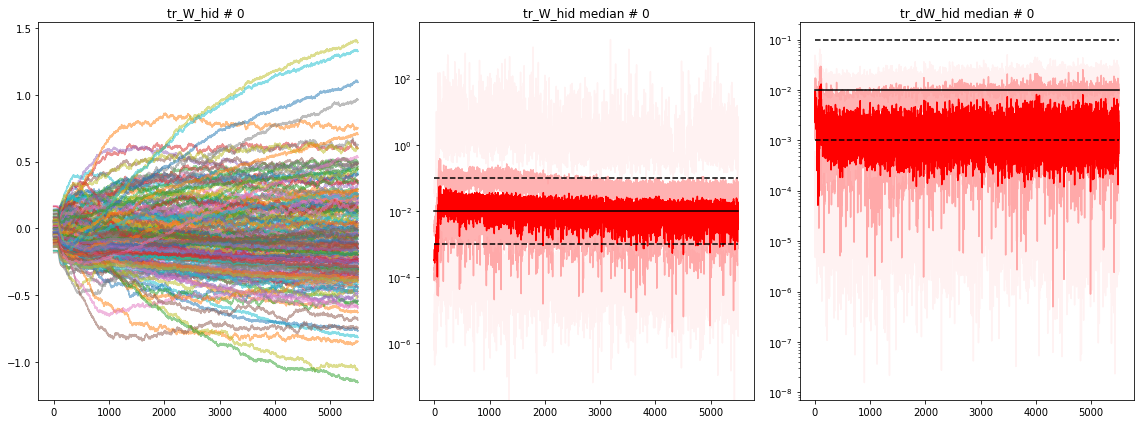

In [177]:
print(expstr)
for n in range(1):
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[16,6])
    plot_weights(tr_W_hid, neuron_nb=n, title='tr_W_hid', axis=ax1)
    plot_update_ratios(tr_W_hid, neuron_nb=n, title='tr_W_hid', color='red', axis=ax2)
    plot_gradients(tr_dW_hid, neuron_nb=n, title='tr_dW_hid', color='red', axis=ax3)
    fig.tight_layout()

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


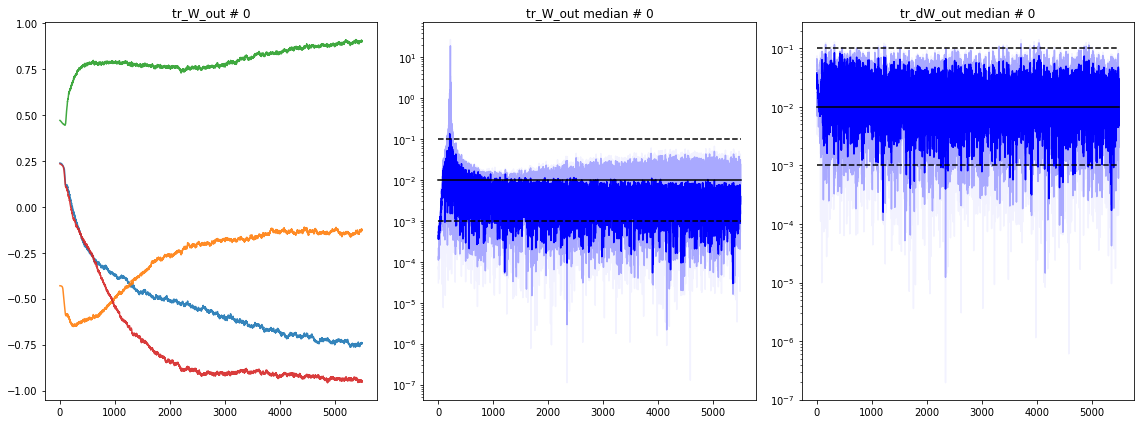

In [178]:
print(expstr)
for n in range(1):
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[16,6])
    plot_weights(tr_W_out, neuron_nb=n, title='tr_W_out', axis=ax1)
    plot_update_ratios(tr_W_out, neuron_nb=n, title='tr_W_out', color='blue', axis=ax2)
    plot_gradients(tr_dW_out, neuron_nb=n, title='tr_dW_out', color='blue', axis=ax3)
    fig.tight_layout()

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


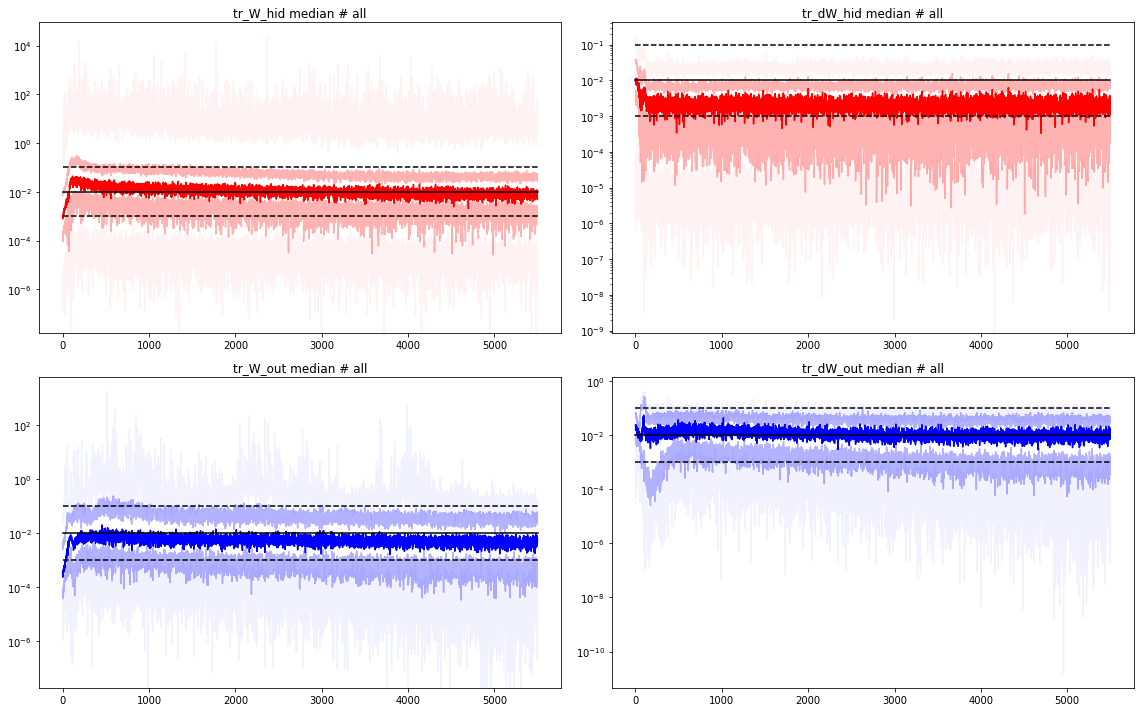

In [179]:
print(expstr)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=[16,10])
plot_update_ratios(tr_W_hid, neuron_nb='all', title='tr_W_hid', color='red', axis=ax1)
plot_gradients(tr_dW_hid, neuron_nb='all', title='tr_dW_hid', color='red', axis=ax2)
plot_update_ratios(tr_W_out, neuron_nb='all', title='tr_W_out', color='blue', axis=ax3)
plot_gradients(tr_dW_out, neuron_nb='all', title='tr_dW_out', color='blue', axis=ax4)
fig.tight_layout()

# Activation Histograms

In [104]:
def plot_3d_histogram(data, es, neuron_nb, funct=None, 
                      skip_first=False, lines_01=True, title=None, color=(1,0,0,1), ax=None, figsize=None):
    assert data.ndim == 3
    
    if funct is None:
        funct = lambda x: x
    
    ni, na, nn = data.shape  # iter, activations (batch size), neurons
    
    if neuron_nb == 'all':
        #data_ia = data.reshape([ni, -1])
        data_ia = data.reshape([-1, es*nn])
    elif np.issubdtype(type(neuron_nb), np.integer):
        #data_ia = data[:,:,neuron_nb]
        data_ia = data[:,:,neuron_nb].reshape(-1, es)
    else:
        raise ValueError('neuron_nb must be int or "all"')
        
    
    
    def interpolate_colors(cstart, cend, n):
        cstart, cend = np.array(cstart), np.array(cend)
        assert cstart.shape == (4,)
        assert cend.shape == (4,)
        if n == 1:  return cend    # if one step, then return end color

        cols = []
        for i in range(n):
            step = i/(n-1)
            cols.append( (1-step)*cstart + step*cend)
        return np.array(cols)
    
    color = np.array(color)
    color_start = np.array(color/4, dtype=float)  # transparent black
    color_end = np.array(color)
    colors = interpolate_colors(color_start, color_end, len(data_ia))
    

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    
    
    ax.view_init(30, -85)
    
    for epoch in range(len(data_ia)):                                     # One line per epoch
        hist, bins = np.histogram(funct(data_ia[epoch,:]), bins=100)      # apply funct and create histogram
        bins = (bins[:-1] + bins[1:])/2                                   # center bins
        hist = hist / np.sum(hist)
        
        hist_0 = hist[0]
        if skip_first:
            bins = bins[1:]
            hist = hist[1:]
        
        ax.plot(xs=bins, ys=hist,
                zs=-epoch,
                zdir='y', 
                color=colors[epoch])
        nb_epochs = len(data_ia)
        if epoch == 0 and lines_01:
            ax.plot(xs=[0,0], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k')
            ax.plot(xs=[1,1], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k', ls='--')
        if epoch == len(data_ia)-1:
            ax.plot(xs=[bins[0],bins[-1]], ys=[0,0], zs=-nb_epochs, zdir='y', color='k')
    
    if skip_first:
        ax.set_xlabel('value ('+str(round((1-hist_0)*100, 2)) + '%)'); ax.set_ylabel('epoch'); ax.set_zlabel('n')
    else:
        ax.set_xlabel('value'); ax.set_ylabel('epoch'); ax.set_zlabel('n')
        
    if title is not None:
        ax.set_title(title)

---

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


/home/marcin/.anaconda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


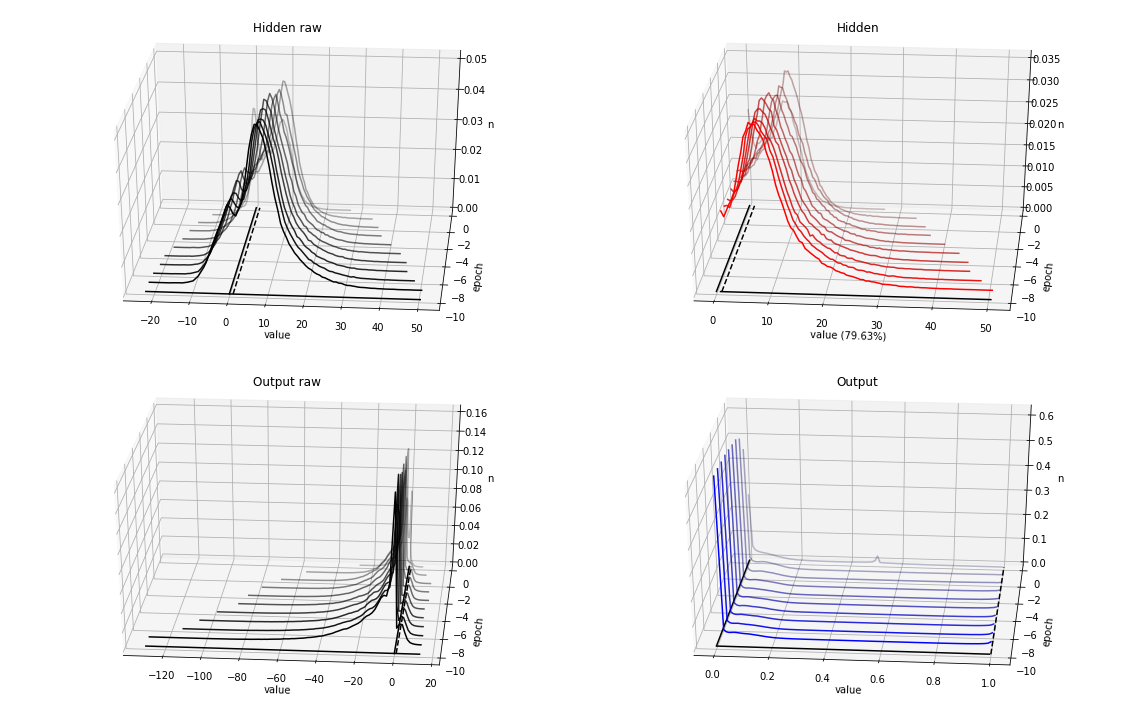

In [180]:
#
#   Hidden ACTIATION HISTOGRAM
#
print(expstr)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='3d'), figsize=[16,10])
plot_3d_histogram(tr_z_hid, es=55000, neuron_nb='all', title='Hidden raw', funct=None, color=(0,0,0,1), ax=ax1)
plot_3d_histogram(tr_z_hid, es=55000, neuron_nb='all', title='Hidden', skip_first=True, funct=act_fun, color=(1,0,0,1), ax=ax2)
plot_3d_histogram(tr_z_out, es=55000, neuron_nb='all', title='Output raw', funct=None, color=(0,0,0,1), ax=ax3)
plot_3d_histogram(tr_z_out, es=55000, neuron_nb='all', title='Output', funct=sigmoid, color=(0,0,1,1), ax=ax4)
fig.tight_layout()

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


IndexError: index 4 is out of bounds for axis 2 with size 4

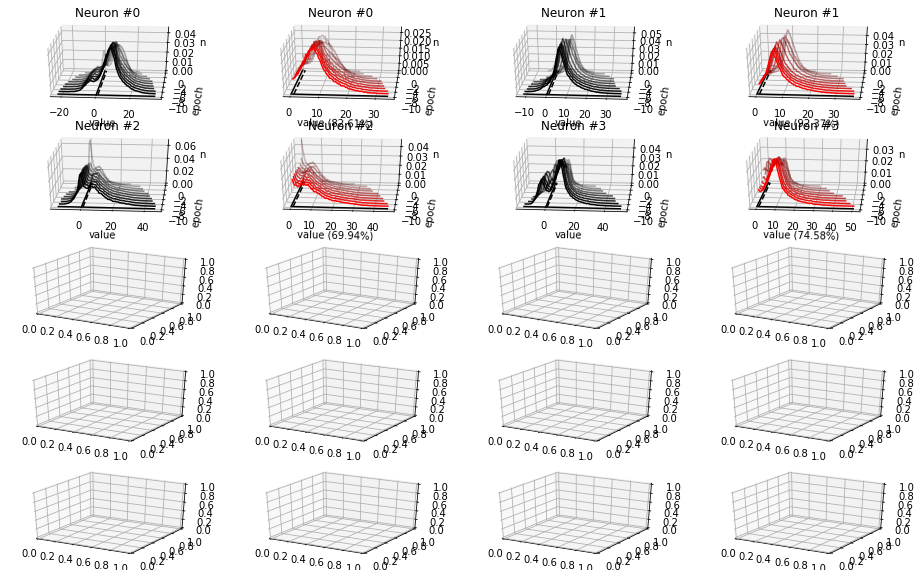

In [181]:
#
#   Hidden NEURONS ACTIVATIONS
#
print(expstr)
plot_n = 10  # tr_z_hid.shape[-1]
fig, axes = plt.subplots(nrows=plot_n//2, ncols=4, subplot_kw=dict(projection='3d'), figsize=[16,2*plot_n/2])

for n in range(plot_n):
    plot_3d_histogram(tr_z_hid, es=55000, neuron_nb=n, title='Neuron #'+str(n), funct=None, color=(0,0,0,1), ax=axes[n//2][2*(n%2)])
    plot_3d_histogram(tr_z_hid, es=55000, neuron_nb=n, title='Neuron #'+str(n), funct=act_fun, skip_first=True, color=(1,0,0,1), ax=axes[n//2][2*(n%2)+1])

fig.tight_layout()

---

Network(tf): 196in->4relu->10sig   init_var=[0.071,0.5]   lr=0.003   batch=100   epochs=10


/home/marcin/.anaconda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


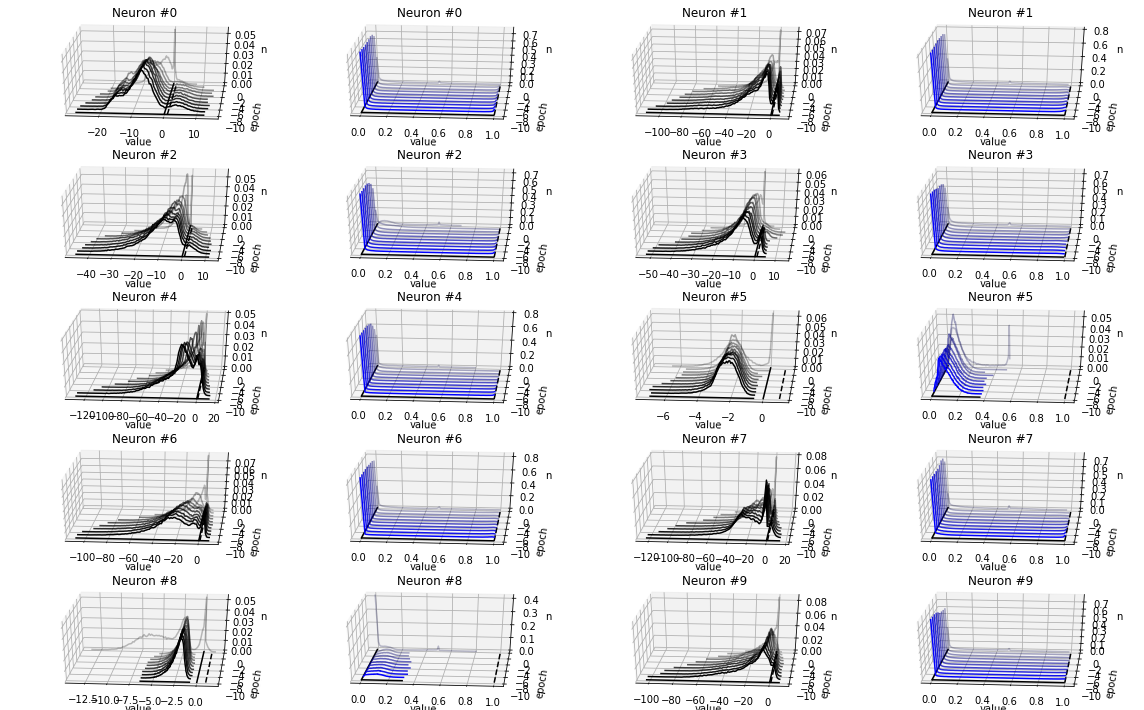

In [182]:
#
#   Output NEURONS ACTIVATIONS
#
print(expstr)
plot_n = 10  # tr_z_out.shape[-1]
fig, axes = plt.subplots(nrows=plot_n//2, ncols=4, subplot_kw=dict(projection='3d'), figsize=[16,2*plot_n/2])

for n in range(plot_n):
    plot_3d_histogram(tr_z_out, es=55000, neuron_nb=n, title='Neuron #'+str(n), funct=None, color=(0,0,0,1), ax=axes[n//2][2*(n%2)])
    plot_3d_histogram(tr_z_out, es=55000, neuron_nb=n, title='Neuron #'+str(n), funct=sigmoid, color=(0,0,1,1), ax=axes[n//2][2*(n%2)+1])
    
fig.tight_layout()

# Other